In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)
import matplotlib as mpl
mpl.style.use('seaborn-whitegrid')
import function

from BS import BS_call, BS_delta, BS_gamma
from display import plot_2Dfunc, plot_3Dfunc
from Optimize import nelder_mead_global

In [2]:
BS_call(100,101,2.0,0.01, 0.25)

14.467015265202313

In [3]:
df = pd.read_excel('Data_TD3.xlsx', header = 2, index_col = 0)
df

,Prix action,Prix option strike 6,"Prix option strike 6,5"
Date,,,
2017-10-02,6.742,NaN,NaN
2017-10-03,6.955,NaN,NaN
2017-10-04,6.910,1.02096,0.59093
2017-10-05,7.006,1.09932,0.65885
2017-10-06,7.000,1.09306,0.65440
...,...,...,...
2018-09-27,6.028,0.37835,0.26191
2018-09-28,5.844,0.28498,0.19737
2018-10-01,5.724,0.24261,0.16974


# Compute BS call prices

First need to transform date into expiry date

Need expiry date for BS formula

In [4]:
# Convert pd.timestamp to int (int=days between two date)
def convert_date_to_maturity(calculation_date, expiry_date):
    return (expiry_date-calculation_date).days

In [5]:
# Initialize column
df['expiry']=np.nan
# Define maturity
maturity=datetime.datetime(2018,12,31)
maturity = pd.Timestamp(maturity)
# Fill expiry col with float expiry
for id_date in df.index:
    df.loc[id_date]['expiry'] = convert_date_to_maturity(id_date, maturity)

# Days to years
df['expiry']=df['expiry'].map(lambda x: x/365)
df

,Prix action,Prix option strike 6,"Prix option strike 6,5",expiry
Date,,,,
2017-10-02,6.742,NaN,NaN,1.246575
2017-10-03,6.955,NaN,NaN,1.243836
2017-10-04,6.910,1.02096,0.59093,1.241096
2017-10-05,7.006,1.09932,0.65885,1.238356
2017-10-06,7.000,1.09306,0.65440,1.235616
...,...,...,...,...
2018-09-27,6.028,0.37835,0.26191,0.260274
2018-09-28,5.844,0.28498,0.19737,0.257534
2018-10-01,5.724,0.24261,0.16974,0.249315


Now we can compute call price using BS formula

In [6]:
vol = 0.20
r = 0.0
K = 6
_k = 6.5
df['BS_price_option_strike_6']=np.nan
df['BS_price_option_strike_6.5']=np.nan
for index in df.index:
    df.loc[index]['BS_price_option_strike_6'] = BS_call(df.loc[index]['Prix action'], K, df.loc[index]['expiry'], r, vol)
    df.loc[index]['BS_price_option_strike_6.5'] = BS_call(df.loc[index]['Prix action'], _k, df.loc[index]['expiry'], r, vol)
df

,Prix action,Prix option strike 6,"Prix option strike 6,5",expiry,BS_price_option_strike_6,BS_price_option_strike_6.5
Date,,,,,,
2017-10-02,6.742,NaN,NaN,1.246575,1.012460,0.717437
2017-10-03,6.955,NaN,NaN,1.243836,1.173632,0.852063
2017-10-04,6.910,1.02096,0.59093,1.241096,1.138193,0.821935
2017-10-05,7.006,1.09932,0.65885,1.238356,1.212687,0.884829
2017-10-06,7.000,1.09306,0.65440,1.235616,1.207450,0.880172
...,...,...,...,...,...,...
2018-09-27,6.028,0.37835,0.26191,0.260274,0.258953,0.085338
2018-09-28,5.844,0.28498,0.19737,0.257534,0.169706,0.047469
2018-10-01,5.724,0.24261,0.16974,0.249315,0.120900,0.029332


Plot the price difference between call price market & call price from BS

There is difference because ............ vol const and equal to 20%

<AxesSubplot:xlabel='Date'>

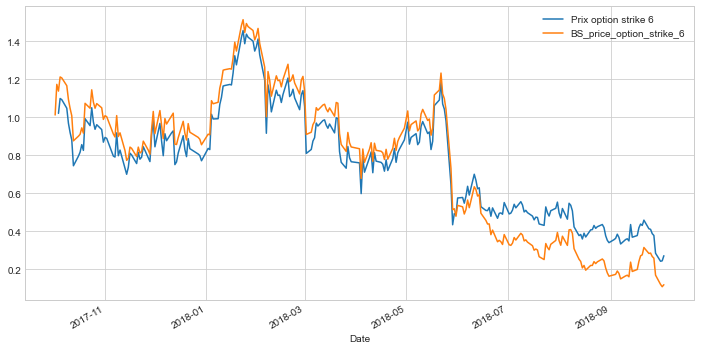

In [7]:
df[['Prix option strike 6','BS_price_option_strike_6']].plot()

Now that we know the BS option prices, we want to replicate it in order to hedge our porfolio

# Portfolio replication with delta hedging

Delta hedging allow the portfolio to have the same sensibility as the replicated option

$V_t$ is the replicated portfolio which invest in $\delta_{t}$ stocks of price $S_t$, whereas the rest is saved with rate $r_t$:

$dV_t = \delta_{t} dS_t + (V − \delta_{t}S_t)r_tdt$


$d(V(t, S_t) = \frac{\partial V}{\partial t}(t,S_t)dt + \frac{\partial V}{\partial S_t}(t,S_t)dS_t + \frac{\partial^{2} V}{\partial S_{t}^2}(t,S_t)\sigma_{t}^2dt$

In order to hedge the portfolio from variation of stock price, we need to sell a quantity $\delta_{t} = \frac{\partial V}{\partial S_t}(t,S_t)$ stocks at maturity

$\delta_{t}$ can be understood as :

If a stock option for XYZ shares has a $\delta_{t}$ of 0.45, if the underlying stock increases in market price by 1 dollar per share, the option value on it will rise by 0.45 dollar per share.

Traders want to know an option's delta since it can tell them how much the value of the option or the premium will rise or fall with a move in the stock's price. The theoretical change in premium for each basis point or $1 change in the price of the underlying is the delta. Meaning that if we buy delta stocks, we will be immune from moove in price since our new portfolio will have the same sensibility.

In [8]:
vol = 0.20
r = 0.0
K = 6
df_rep = pd.DataFrame(index = pd.to_datetime(df.index), 
                      columns = ['expiry','stock_price','option_price','delta', 'replicated_portfolio', 'poche_action', 'poche_cash'],
                     dtype = 'float')
df_rep['expiry'] = df['expiry'].copy()
df_rep['stock_price'] = df['Prix action'].copy()
df_rep['option_price'] = df['BS_price_option_strike_6'].copy()


for i, index in enumerate(df_rep.index):
    df_rep.loc[index]['delta'] = BS_delta(df_rep.loc[index]['stock_price'],K,df_rep.loc[index]['expiry'], r, vol)
    if i == 0 :
        df_rep.iloc[0]['replicated_portfolio'] = df_rep.iloc[0]['option_price']
    else:
        df_rep.loc[index]['poche_action'] = df_rep.loc[index]['delta']*df_rep.loc[index]['stock_price']
        df_rep.iloc[i]['replicated_portfolio'] = df_rep.iloc[i-1]['replicated_portfolio'] + df_rep.iloc[i-1]['delta']*(df_rep.iloc[i]['stock_price']-df_rep.iloc[i-1]['stock_price'])
        df_rep.loc[index]['poche_cash'] = df_rep.loc[index]['replicated_portfolio'] - df_rep.loc[index]['delta']*df_rep.loc[index]['stock_price']
df_rep

,expiry,stock_price,option_price,delta,replicated_portfolio,poche_action,poche_cash
Date,,,,,,,
2017-10-02,1.246575,6.742,1.012460,0.736896,1.012460,NaN,NaN
2017-10-03,1.243836,6.955,1.173632,0.780447,1.169419,5.428007,-4.258588
2017-10-04,1.241096,6.910,1.138193,0.771918,1.134298,5.333951,-4.199652
2017-10-05,1.238356,7.006,1.212687,0.790382,1.208403,5.537416,-4.329013
2017-10-06,1.235616,7.000,1.207450,0.789458,1.203660,5.526206,-4.322546
...,...,...,...,...,...,...,...
2018-09-27,0.260274,6.028,0.258953,0.538497,0.222669,3.246058,-3.023389
2018-09-28,0.257534,5.844,0.169706,0.417298,0.123586,2.438692,-2.315106
2018-10-01,0.249315,5.724,0.120900,0.336647,0.073510,1.926968,-1.853458


<AxesSubplot:xlabel='Date'>

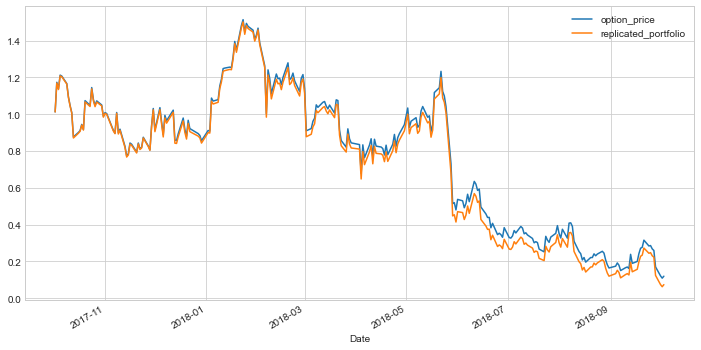

In [9]:
df_rep[['option_price', 'replicated_portfolio']].plot()

<AxesSubplot:xlabel='Date'>

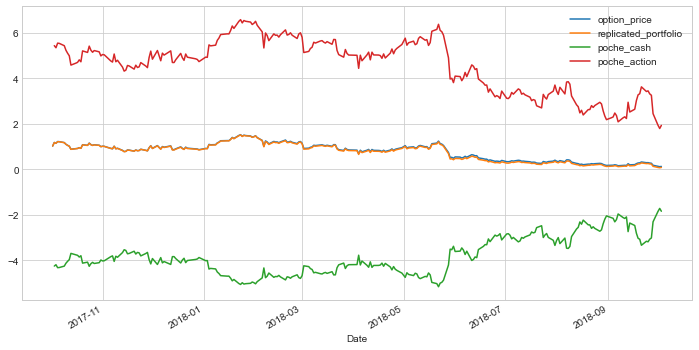

In [10]:
df_rep[['option_price', 'replicated_portfolio','poche_cash', 'poche_action']].plot()

We obtain a little difference between option_price and replicated_portofolio because we adjust delta each day

-> the frequency is important when replicating a portofolio, more frequent implie more precise but also more fees du to transaction

One of the primary drawbacks of delta hedging is the necessity of constantly watching and adjusting the positions involved. Depending on the movement of the stock, the trader has to frequently buy and sell securities to avoid being under or over hedged.

Also, the number of transactions involved in delta hedging can become expensive since trading fees are incurred as adjustments are made to the position. It can be particularly expensive when the hedging is done with options, as these can lose time value, sometimes trading lower than the underlying stock has increased.

Delta hedging can benefit traders when they anticipate a strong move in the underlying stock but run the risk of being over hedged if the stock doesn't move as expected. If over hedged positions have to unwind, the trading costs increase.

# Gamma Hedging

In options trading, delta refers to a change in the price of an option contract per change in the price of the underlying asset. Gamma refers to the rate of change of delta per change in the price of the underlying asset. 
(La sensibilité du delta par rapport au variation de prix)

# Portfolio replication with delta and gamma hedging

Delta & Gamma hedging allow the portfolio to have the same sensibility and convexité as the replicated option



In [11]:
vol = 0.20
r = 0.0
K = 6
_K = 6.5
df_rep = pd.DataFrame(index = pd.to_datetime(df.index), 
                      columns = ['expiry','stock_price','option_price_K6','option_price_K6.5',
                                 'delta_K6','delta_K6.5','gamma_K6', 'gamma_K6.5',
                                 'replicated_portfolio', 'quantity_stock', 'quantity_option_K6.5',
                                 'poche_action', 'poche_cash', 'poche_option_K6.5'],
                     dtype = 'float')
df_rep['expiry'] = df['expiry'].copy()
df_rep['stock_price'] = df['Prix action'].copy()
df_rep['option_price_K6'] = df['BS_price_option_strike_6'].copy()
df_rep['option_price_K6.5'] = df['BS_price_option_strike_6.5'].copy()

for i, index in enumerate(df_rep.index):
    df_rep.loc[index]['delta_K6'] = BS_delta(df_rep.loc[index]['stock_price'],K,df_rep.loc[index]['expiry'], r, vol)
    df_rep.loc[index]['delta_K6.5'] = BS_delta(df_rep.loc[index]['stock_price'],_K,df_rep.loc[index]['expiry'], r, vol)
    df_rep.loc[index]['gamma_K6'] = BS_gamma(df_rep.loc[index]['stock_price'],K,df_rep.loc[index]['expiry'], r, vol)
    df_rep.loc[index]['gamma_K6.5'] = BS_gamma(df_rep.loc[index]['stock_price'],_K,df_rep.loc[index]['expiry'], r, vol)
   
    df_rep.loc[index]['quantity_stock'] = (df_rep.loc[index]['delta_K6'] - 
                                        df_rep.loc[index]['delta_K6.5']*df_rep.loc[index]['gamma_K6']/df_rep.loc[index]['gamma_K6.5'])
    df_rep.loc[index]['poche_action'] =  df_rep.loc[index]['quantity_stock']*df_rep.loc[index]['stock_price']
    df_rep.loc[index]['quantity_option_K6.5'] = df_rep.loc[index]['gamma_K6']/df_rep.loc[index]['gamma_K6.5']
    df_rep.loc[index]['poche_option_K6.5'] = df_rep.loc[index]['quantity_option_K6.5']*df_rep.loc[index]['option_price_K6.5']
    
    if i == 0 :
        df_rep.iloc[i]['replicated_portfolio'] = df_rep.iloc[i]['option_price_K6']
    else:
        df_rep.iloc[i]['replicated_portfolio'] = df_rep.iloc[i-1]['replicated_portfolio'] + df_rep.iloc[i-1]['quantity_stock']*(df_rep.iloc[i]['stock_price']-df_rep.iloc[i-1]['stock_price'])+ df_rep.iloc[i-1]['quantity_option_K6.5']*(df_rep.iloc[i]['option_price_K6.5']-df_rep.iloc[i-1]['option_price_K6.5'])
    
    df_rep.loc[index]['poche_cash'] = df_rep.loc[index]['replicated_portfolio'] - df_rep.loc[index]['poche_action'] - df_rep.loc[index]['poche_option_K6.5']
df_rep

,expiry,stock_price,option_price_K6,option_price_K6.5,delta_K6,delta_K6.5,gamma_K6,gamma_K6.5,replicated_portfolio,quantity_stock,quantity_option_K6.5,poche_action,poche_cash,poche_option_K6.5
Date,,,,,,,,,,,,,,
2017-10-02,1.246575,6.742,1.012460,0.717437,0.736896,0.608477,0.216772,0.255134,1.012460,0.219911,0.849638,1.482638,-1.079740,0.609562
2017-10-03,1.243836,6.955,1.173632,0.852063,0.780447,0.660876,0.190640,0.235955,1.173684,0.246492,0.807950,1.714354,-1.229093,0.688424
2017-10-04,1.241096,6.910,1.138193,0.821935,0.771918,0.650227,0.196300,0.240523,1.138250,0.241243,0.816138,1.666988,-1.199550,0.670812
2017-10-05,1.238356,7.006,1.212687,0.884829,0.790382,0.672962,0.184633,0.231411,1.212740,0.253456,0.797855,1.775712,-1.268938,0.705965
2017-10-06,1.235616,7.000,1.207450,0.880172,0.789458,0.671660,0.185474,0.232239,1.207503,0.253047,0.798634,1.771330,-1.266762,0.702935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-27,0.260274,6.028,0.258953,0.085338,0.538497,0.245782,0.645599,0.511987,0.258080,0.228573,1.260968,1.377839,-1.227368,0.107609
2018-09-28,0.257534,5.844,0.169706,0.047469,0.417298,0.159275,0.658089,0.408992,0.168270,0.161017,1.609050,0.940982,-0.849091,0.076379
2018-10-01,0.249315,5.724,0.120900,0.029332,0.336647,0.110635,0.638562,0.330316,0.119766,0.122769,1.933187,0.702727,-0.639667,0.056705


<AxesSubplot:xlabel='Date'>

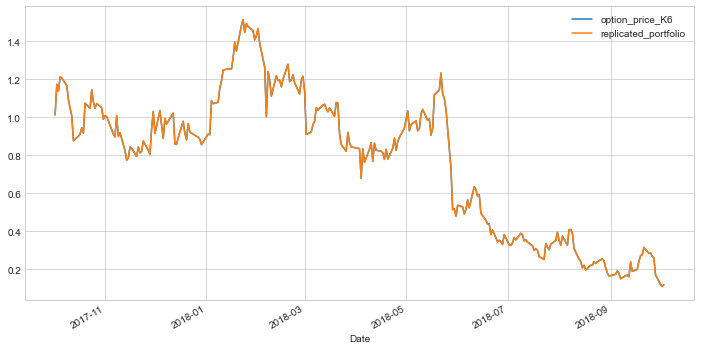

In [12]:
df_rep[['option_price_K6', 'replicated_portfolio']].plot()

<AxesSubplot:xlabel='Date'>

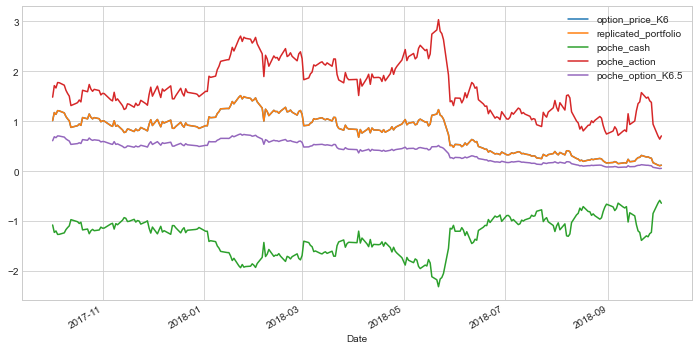

In [13]:
df_rep[['option_price_K6','replicated_portfolio','poche_cash', 'poche_action', 'poche_option_K6.5']].plot()

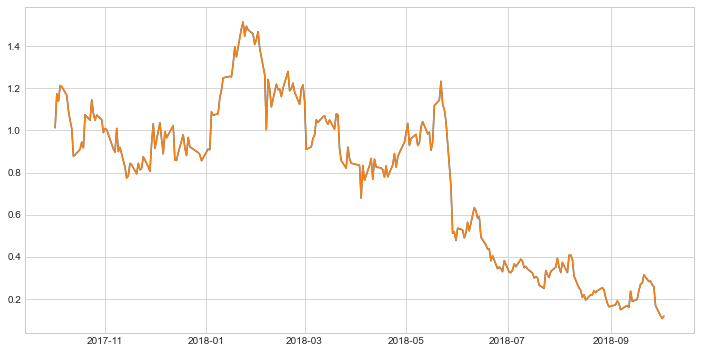

In [14]:
plt.plot(df_rep['poche_cash'] + df_rep['poche_action'] + df_rep['poche_option_K6.5'] )
plt.plot(df_rep['option_price_K6'])

# Represent call price in function of volatility

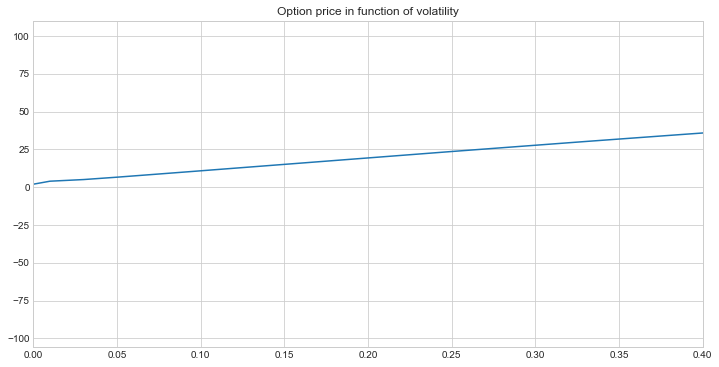

In [15]:
plot_2Dfunc(function.BS_european_call_price, "Option price in function of volatility")

In [16]:
df_res = df[["expiry","Prix action","Prix option strike 6","Prix option strike 6,5"]].copy()
df_res

,expiry,Prix action,Prix option strike 6,"Prix option strike 6,5"
Date,,,,
2017-10-02,1.246575,6.742,NaN,NaN
2017-10-03,1.243836,6.955,NaN,NaN
2017-10-04,1.241096,6.910,1.02096,0.59093
2017-10-05,1.238356,7.006,1.09932,0.65885
2017-10-06,1.235616,7.000,1.09306,0.65440
...,...,...,...,...
2018-09-27,0.260274,6.028,0.37835,0.26191
2018-09-28,0.257534,5.844,0.28498,0.19737
2018-10-01,0.249315,5.724,0.24261,0.16974


In [26]:
df_res['implied_volatility_K6'] = np.nan
df_res['implied_volatility_K6.5'] = np.nan
for index in df_res.index[2:]:
    dict_param_K6 = {
        'K':6,
        'S':df_res.loc[index]['Prix action'],
        'r': 0.0,
        'T' : df_res.loc[index]['expiry'],
        'market_price': df_res.loc[index]['Prix option strike 6']
    }
    dict_param_K6_5 = {
        'K':6.5,
        'S':df_res.loc[index]['Prix action'],
        'r': 0.0,
        'T' : df_res.loc[index]['expiry'],
        'market_price': df_res.loc[index]['Prix option strike 6,5']
    }
    df_res.loc[index]['implied_volatility_K6'] = nelder_mead_global(1, function.BS_european_call,0,1, **dict_param_K6)[0]
    df_res.loc[index]['implied_volatility_K6.5'] = nelder_mead_global(1, function.BS_european_call,0,1, **dict_param_K6_5)[0]
df_res


,expiry,Prix action,Prix option strike 6,"Prix option strike 6,5",implied_volatility,implied_volatility_K6,implied_volatility_K6.5
Date,,,,,,,
2017-10-02,1.246575,6.742,NaN,NaN,NaN,NaN,NaN
2017-10-03,1.243836,6.955,NaN,NaN,NaN,NaN,NaN
2017-10-04,1.241096,6.910,1.02096,0.59093,0.145859,0.145860,0.116970
2017-10-05,1.238356,7.006,1.09932,0.65885,0.144787,0.144786,0.116564
2017-10-06,1.235616,7.000,1.09306,0.65440,0.144310,0.144309,0.116686
...,...,...,...,...,...,...,...
2018-09-27,0.260274,6.028,0.37835,0.26191,0.297814,0.297814,0.361408
2018-09-28,0.257534,5.844,0.28498,0.19737,0.298546,0.298546,0.362254
2018-10-01,0.249315,5.724,0.24261,0.16974,0.312174,0.312171,0.376125
